In [77]:
# Run this block to load important libraries and set things up
import torch
from torch import nn
import numpy as np
import scipy.signal
import math

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import cv2
import glob
import numpy as np
import random

# Chest X-Ray Image Classification

## Data Exploration:

For this project, the data takes the form of images, which can be manipulated a limited number of ways. To keep things simple, this project will simply ensure that images will be converted into a form that Pytorch algorithms can handle. 

### Step 1: Data Collection

The data from the Kaggle dataset is already cleaned, with "clusters of defective images are removed during the curation process and a refined dataset is obtained which is available for download." All that is left to do regarding the data is to collect it and reshape it into a way that can be processed by the SVM classifier.

This involves:
* Assigning labels
* Reading and resizing images 

It is imperative to resize the images, as processing very large images can be difficult, especially if we're treating each pixel as a feature.

#### 1A. Assigning labels
Function to return a label associated with a given path. If the path does not exist, raise an `exception`

In [2]:
def get_label_from_path(path):
    if "COVID-19" in path:
        return 0
#         return "Covid"
    elif "Normal" in path:
        return 1
#         return "Normal"
    elif "Pneumonia-Viral" in path:
        return 2
#         return "Pneumonia-Viral"
    else:
        raise Exception("Path does not contain a valid feature label: ", path)
        
def get_label_from_idx(idx):
    if idx == 0:
        return "COVID-19"
    elif idx == 1:
        return "NORMAL"
    elif idx == 2:
        return "Pneumonia-Viral"
    else:
        raise Exception("Idx does not correspond to a class")

#### 1B. Reading and Resizing Images
Function to read images from a folder given a path and resize them

In [3]:
def collect_images(path, total_features, total_labels):
    temp_files = []
    [temp_files.extend(glob.glob(path + '*.' + e)) for e in ext]
    temp_images = [cv2.imread(file) for file in temp_files]
    resized_images = []
    for image in temp_images:
        resized_images.append(cv2.resize(image, (100, 100)))
        total_labels.append(get_label_from_path(path))
    total_features.extend(resized_images)

Utilize the `collect_images` and `get_label_from_path` methods to read in images from the **Curated-dataset**.

Keep a collection of all the images and their features.

Temporarily keep a train and test split (80-20) to model a small classifier later.

In [4]:
train_paths = ["Curated-dataset/COVID-19/", "Curated-dataset/Normal/", "Curated-dataset/Pneumonia-Viral/"]
# test_paths = ["test/Covid/", "test/Normal/", "test/Viral_Pneumonia/"]
ext = ['png', 'jpg', 'jpeg']    # Add image formats here
all_images = []
all_labels = []
print("Downloading images...")

# Collect all images from Curated-dataset
for path in train_paths:
    collect_images(path, all_images, all_labels)

# After collecting all images, randomize them
temp_arr = []
for i in range(len(all_images)):
    temp_arr.append((all_images[i], all_labels[i]))
print("Shuffling images...")

random.shuffle(temp_arr)
for i in range(len(all_images)):
    all_images[i] = temp_arr[i][0]
    all_labels[i] = temp_arr[i][1]

print("Partitioning images...")
# Temporarily keep a partition of training data and testing data
FIFTH_OF_DATA = int(0.2 * len(all_images))
train_images = all_images[: 4 * FIFTH_OF_DATA]
train_labels = all_labels[: 4 * FIFTH_OF_DATA]
test_images = all_images[4 * FIFTH_OF_DATA:]
test_labels = all_labels[4 * FIFTH_OF_DATA:]

Shuffling images...
Partitioning images...


Verify the dimensions of the data. 

In [5]:
print("Training data: ", len(train_images), len(train_labels))
print("Testing data: ", len(test_images), len(test_labels))
print("All data: ", len(all_images), len(all_labels))

Training data:  4964 4964
Testing data:  1243 1243
All data:  6207 6207


Visualize some examples of the images.

<class 'numpy.ndarray'>


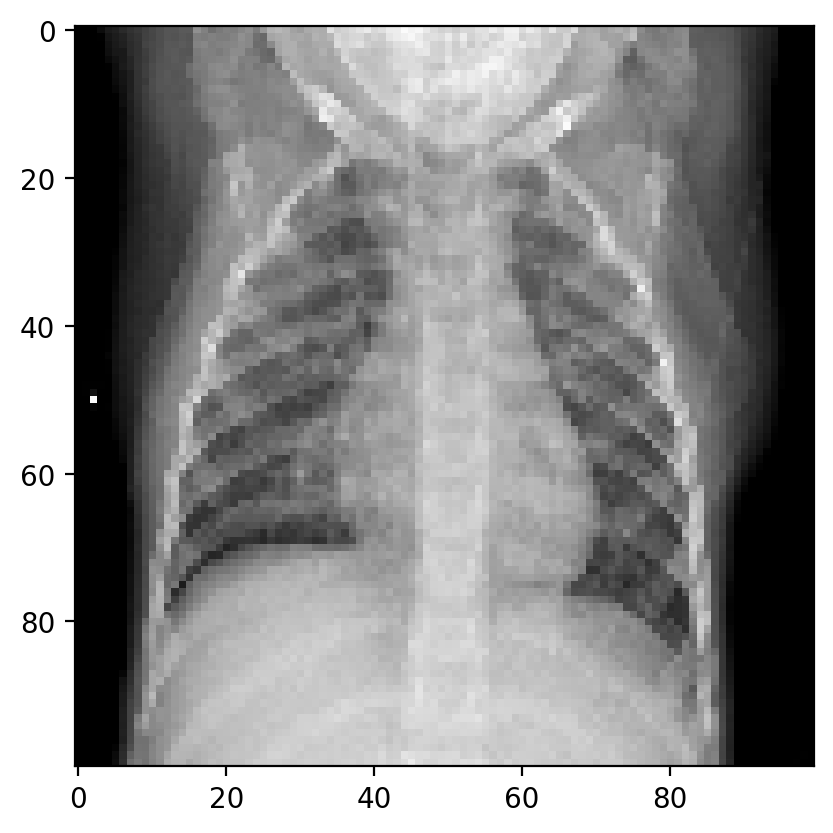

<class 'numpy.ndarray'>


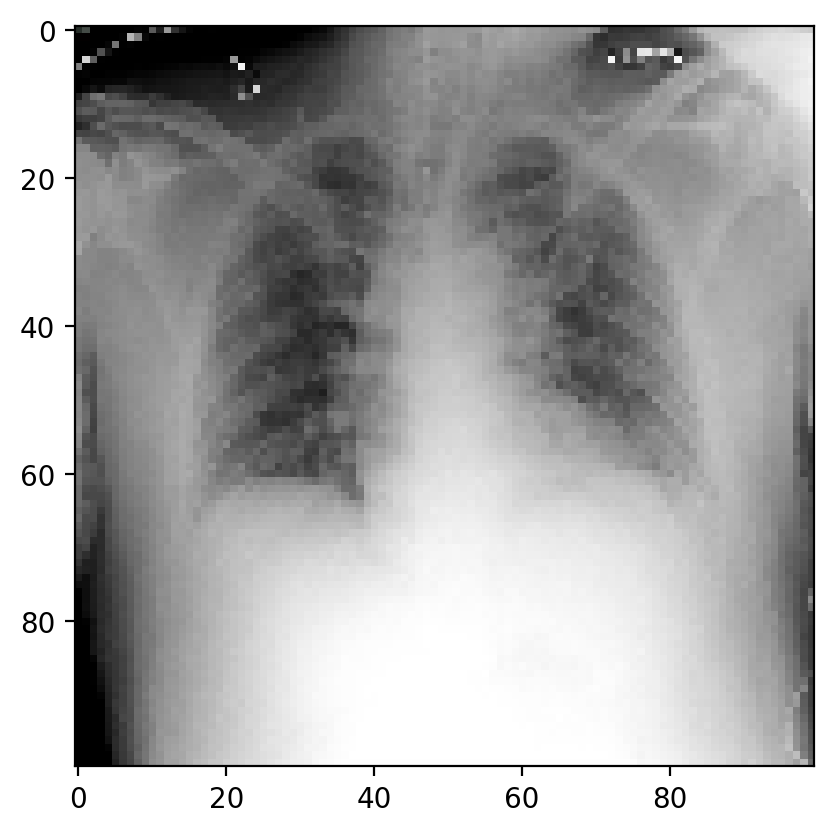

<class 'numpy.ndarray'>


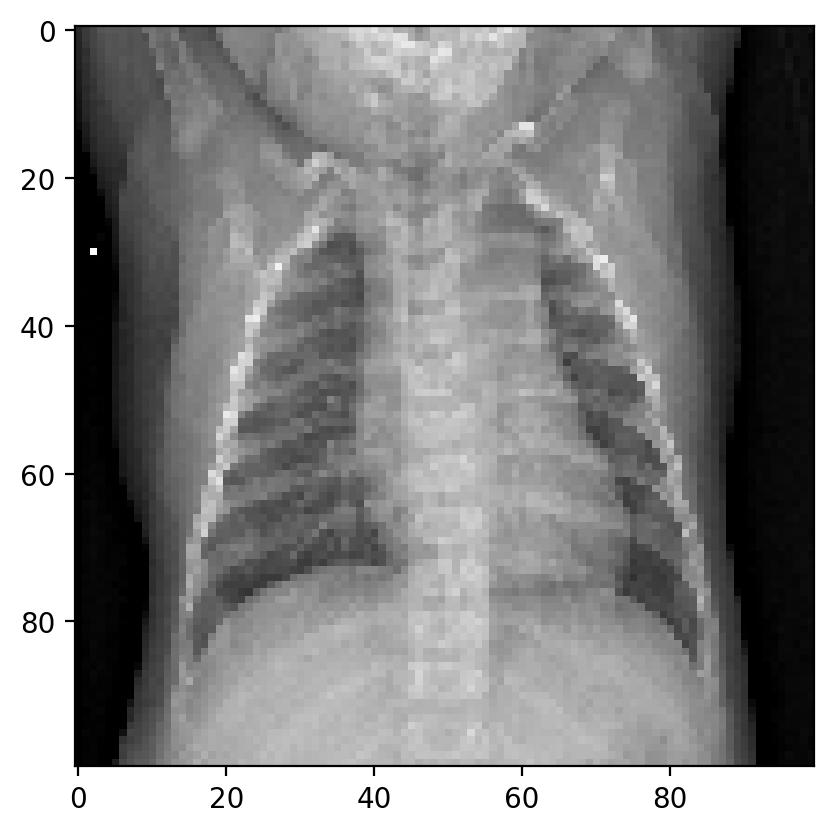

In [6]:
for i in range(3):
    random_img = random.choice(train_images)
    print(type(random_img))
    plt.imshow(random_img, interpolation='nearest')
    plt.show()

#### 1C. Flattening Images

Create a method to flatten an array of images. Apply that to `train_images`, `test_images`, and `all_images`

Function to make all images into tensors

In [7]:
def torch_inputs(inputs):
    l = []
    for i in range(len(inputs)):
        l.append(torch.permute(torch.tensor(inputs[i], dtype=torch.float32), (2, 0, 1)))
    return l
        
def torch_labels(labels):
    l = []
    for i in range(len(labels)):
        l.append(torch.tensor(labels[i], dtype=torch.long))
    return l

In [8]:
# flatten each collection of images
torch_train_images = torch_inputs(train_images)
torch_test_images = torch_inputs(test_images)
torch_all_images = torch_inputs(all_images)


torch_train_labels = torch_labels(train_labels)
torch_test_labels = torch_labels(test_labels)
torch_all_labels = torch_labels(all_labels)

print(torch_train_images[0].shape)
# print(train_images[0])
print(len(train_images))

torch.Size([3, 100, 100])
4964


## Model: Convolutional Neural Net

The first model to explore is the CNN classifier. Characteristics of CNN classifiers include:
* Translation invariance - moving the images left and right won't affect the accuracy
* Computationally efficient - compared to fully-connected neural networks

### Step 1: Define CNN Architecture

Create dataloaders. Since my dataset needed to be cleaned by me, I will be manually batching.

In [81]:
def batch_generator(images, labels, batch_size):
    num_samples = len(images)
    num_batches = num_samples // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]
        yield torch.stack(batch_images, dim=0), torch.stack(batch_labels, dim=0)

In [82]:
class xrayNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(3)
        )

        
    def forward(self, x):
        return self.layers(x)

Tip: An easy way to check if you got the dimensions right is to test your model on a single batch. Iteratively add each layer transformation to the input, and ensure the shape is right at each stage.

In [83]:
model = xrayNN()
batch_size = 64
test_images_batches = []
test_labels_batches = []

for batch_images, batch_labels in batch_generator(torch_train_images, torch_train_labels, batch_size):
    print(batch_images.shape, batch_labels.shape)
    print(model)
    outputs = model(batch_images)
    print(outputs.shape)
    break

torch.Size([64, 3, 100, 100]) torch.Size([64])
xrayNN(
  (layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): LazyLinear(in_features=0, out_features=3, bias=True)
  )
)
torch.Size([64, 3])


### Step 2: Train and Test Model

#### 2a. Define methods to train and test network

In [84]:
def train_network(model, torch_train_images, torch_train_labels, criterion, optimizer, nepoch=100):
    losses = []
    try:
        for epoch in range(nepoch):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for batch_images, batch_labels in batch_generator(torch_train_images, torch_train_labels, batch_size):
                optimizer.zero_grad()
                outputs = model(batch_images)
#                 print(outputs.shape)
#                 print(batch_labels.shape)
                loss = criterion(outputs, batch_labels)
                losses.append(loss.item())
#                 print(loss)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
    except KeyboardInterrupt:
        print('Exiting from training early')
    return losses

def test_network(model, torch_test_images, torch_test_labels, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for batch_images, batch_labels in batch_generator(torch_test_images, torch_test_labels, batch_size):
            outputs = model(batch_images)
             # get predicted class label for each test example.
            predicted = torch.tensor([np.argmax(output) for output in outputs])
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            true.append(batch_labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [85]:
model = xrayNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # Using weight decay in optimizer|

In [57]:
losses = train_network(model, torch_train_images, torch_train_labels, criterion, optimizer, 50)

EPOCH 0
 Train loss: 1.90855
EPOCH 1
 Train loss: 0.24738
EPOCH 2
 Train loss: 0.21155
EPOCH 3
 Train loss: 0.18037
EPOCH 4
 Train loss: 0.16489
EPOCH 5
 Train loss: 0.14551
EPOCH 6
 Train loss: 0.12406
EPOCH 7
 Train loss: 0.10950
EPOCH 8
 Train loss: 0.09090
EPOCH 9
 Train loss: 0.07314
EPOCH 10
 Train loss: 0.07198
EPOCH 11
 Train loss: 0.07418
EPOCH 12
 Train loss: 0.06598
EPOCH 13
 Train loss: 0.04920
EPOCH 14
 Train loss: 0.03926
EPOCH 15
 Train loss: 0.03142
EPOCH 16
 Train loss: 0.03473
EPOCH 17
 Train loss: 0.07095
EPOCH 18
 Train loss: 0.03757
EPOCH 19
 Train loss: 0.02916
EPOCH 20
 Train loss: 0.02977
EPOCH 21
 Train loss: 0.02030
EPOCH 22
 Train loss: 0.01645
EPOCH 23
 Train loss: 0.01916
EPOCH 24
 Train loss: 0.02140
EPOCH 25
 Train loss: 0.01749
EPOCH 26
 Train loss: 0.02122
EPOCH 27
 Train loss: 0.02699
EPOCH 28
 Train loss: 0.06304
EPOCH 29
 Train loss: 0.08431
EPOCH 30
 Train loss: 0.03963
EPOCH 31
 Train loss: 0.10963
EPOCH 32
 Train loss: 0.06050
EPOCH 33
 Train loss

#### Step 2b. Plot the losses recorded above. Notice the continual decreasing.

Text(0, 0.5, 'Loss')

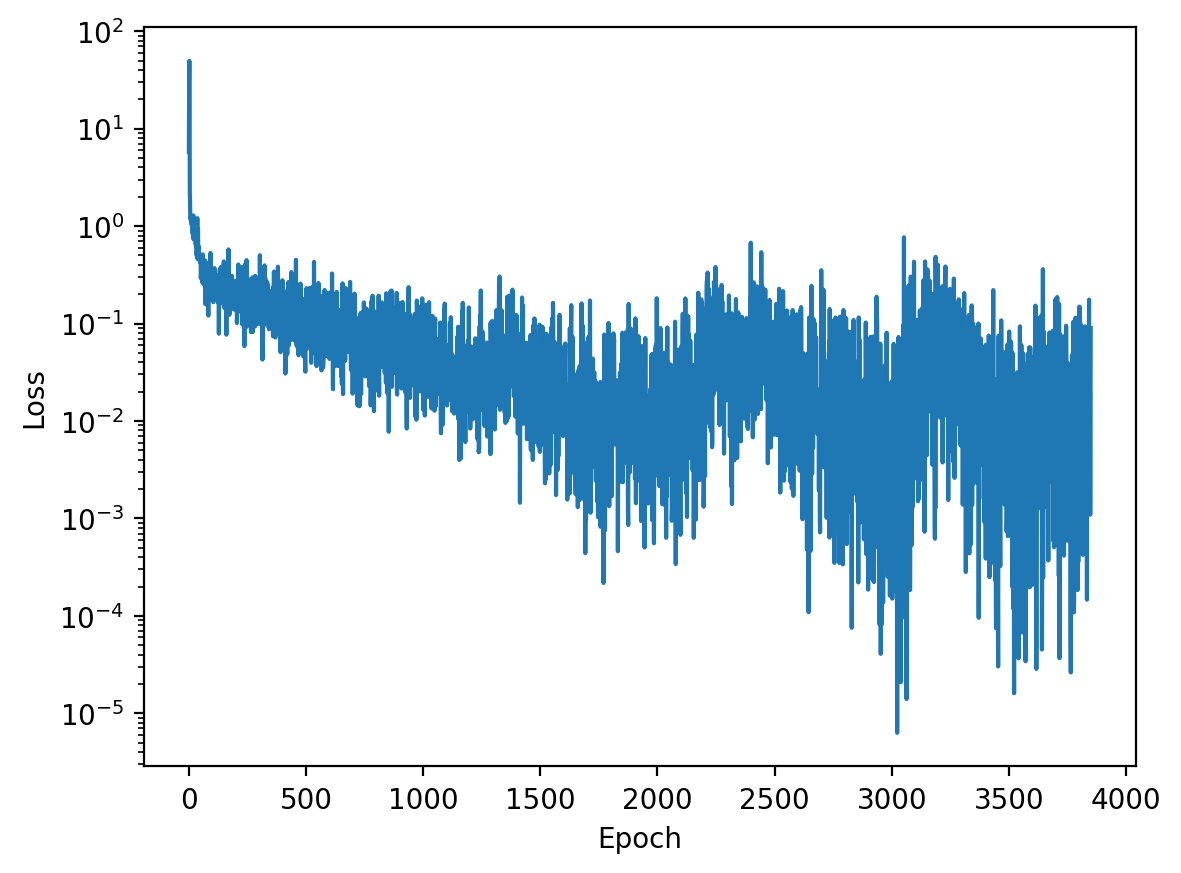

In [58]:
# plot the losses (semilogy is your friend)
plt.figure()
plt.semilogy(range(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

#### Step 2c. Save the model to save a lot of time!

In [59]:
torch.save(model.state_dict(), 'model_weights.pth') # save model!

In [86]:
# create and reload model
model = xrayNN()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

/Users/allenjue/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


xrayNN(
  (layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): LazyLinear(in_features=0, out_features=3, bias=True)
  )
)

#### 2d. Test the network and display a contingency matrix

In [141]:
acc, true, pred = test_network(model, torch_test_images, torch_test_labels, "Weight Decay")

Weight Decay accuracy: 97.615


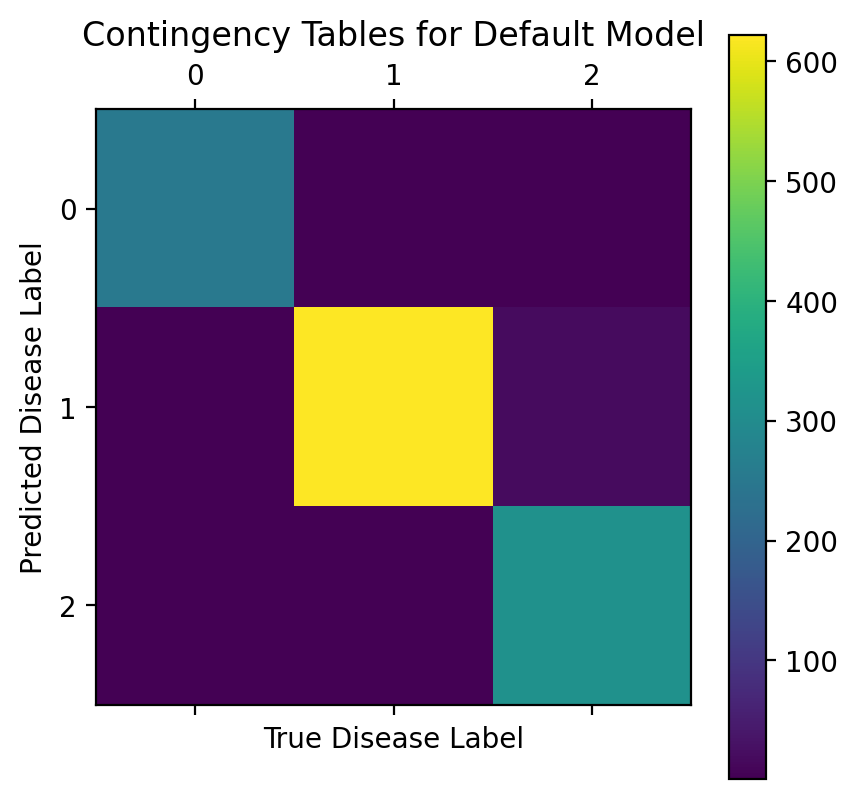

In [142]:
# create contingency table
contingency = np.zeros((3, 3))
for (p, t) in zip(pred, true):
    contingency[p][t] += 1
plt.matshow(contingency)
plt.title("Contingency Tables for Default Model")
plt.xlabel("True Disease Label")
plt.ylabel("Predicted Disease Label")
plt.colorbar()

#### 2e. Visualize the first layer

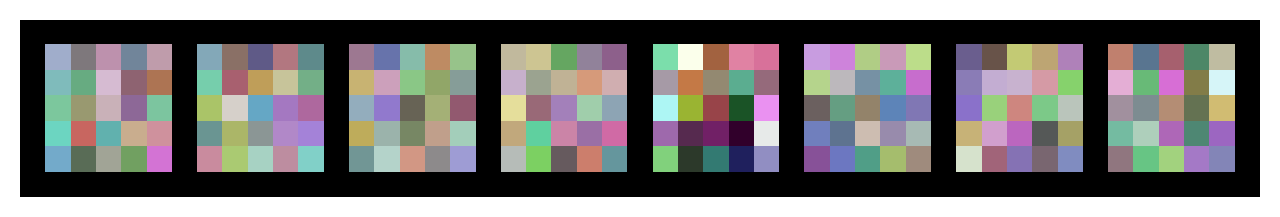

In [64]:
from torchvision import utils

# Code found at: https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch 

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

layer = 0
filter = model.layers[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

### Step 3. Computational Tests

#### 3a. Shuffle patches of images

Use skimage to change the images into blocks. Shuffle these matrices and concatenate them together.

In [165]:
from skimage.util import view_as_blocks
import matplotlib.pyplot as plt

def shuffle_images(images):
    shuffled_images = []
    # Assuming train_images is a list of images and train_images[0] is the first image
    for image in images:
        temp = []

        # Split the image into blocks of size (20, 20, 3)
        blocks = view_as_blocks(image, (20, 20, 3))


        for i in range(5):
            for j in range(5):
                temp.append(blocks[i][j])
        random.shuffle(temp)
        
        # Concatenate the matrices along the rows to create a big matrix
        big_matrix = np.concatenate(temp, axis=0)

        # Reshape the big matrix to (100, 100, 3)
        big_matrix = big_matrix.reshape(5, 5, 20, 20, 3)

        # Combine the small matrices into one big matrix
        result = np.concatenate([np.concatenate(row, axis=1) for row in big_matrix], axis=0)

        # Verify the shape of the resulting matrix
        shuffled_images.append(result)
    return shuffled_images


Display a few of the shuffled images

<class 'numpy.ndarray'>


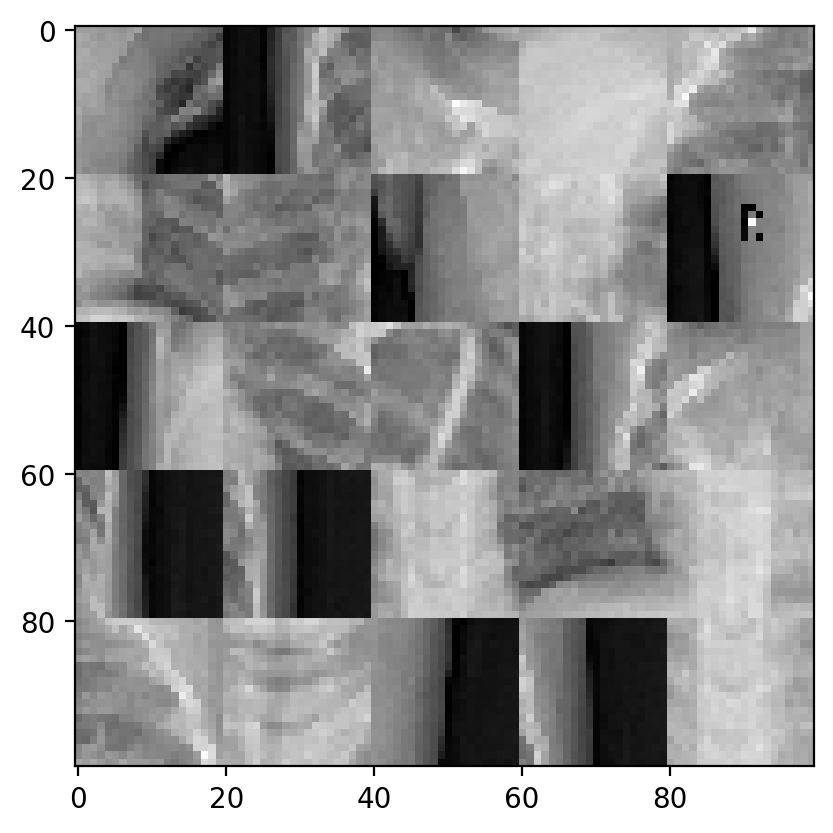

<class 'numpy.ndarray'>


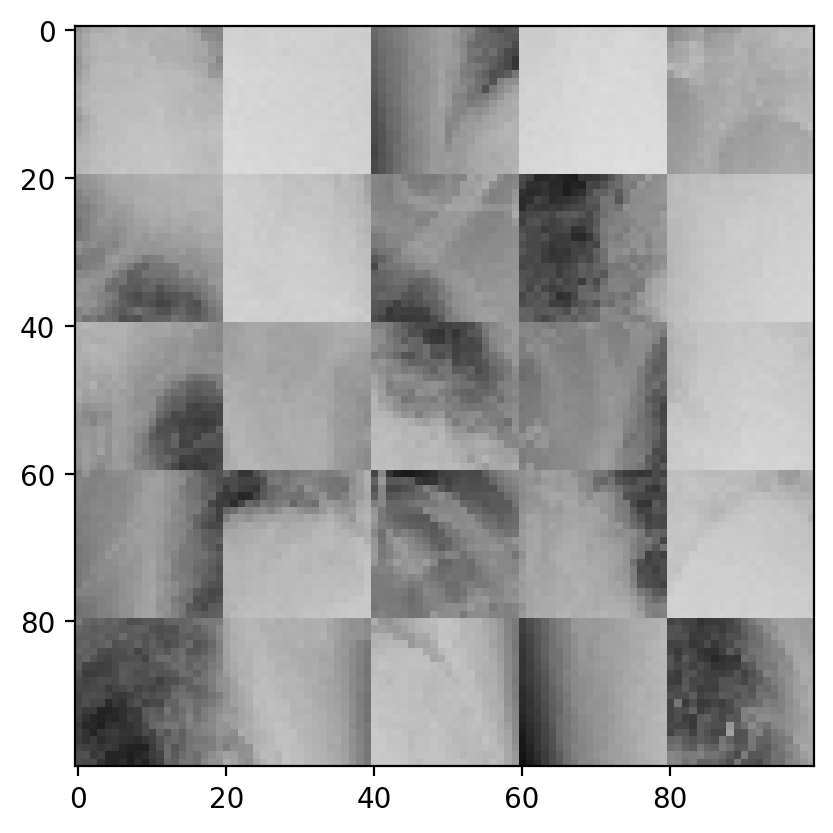

<class 'numpy.ndarray'>


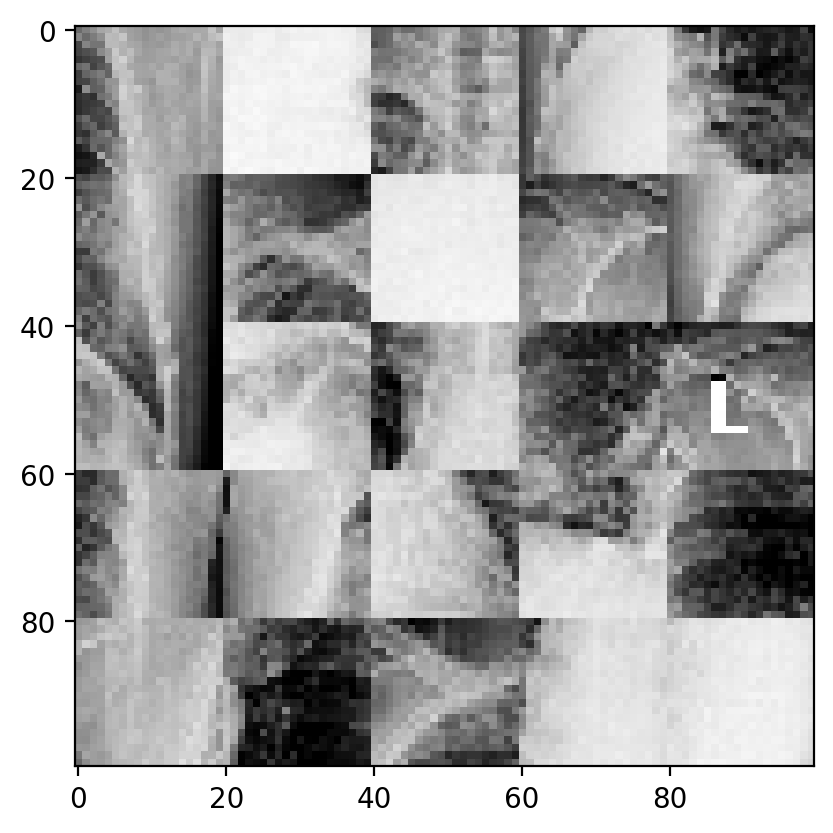

In [166]:
shuffled_test_images = shuffle_images(test_images)
for i in range(3):
    random_img = random.choice(shuffled_test_images)
    print(type(random_img))
    plt.imshow(random_img, interpolation='nearest')
    plt.show()

#### 3b. Test the network on shuffled images and display a contingency matrix

In [167]:
torch_shuffled_test_images = torch_inputs(shuffled_test_images)
torch_test_labels = torch_labels(test_labels)

acc, true, pred = test_network(model, torch_shuffled_test_images, torch_test_labels, "Shuffled Images")

Shuffled Images accuracy: 22.368


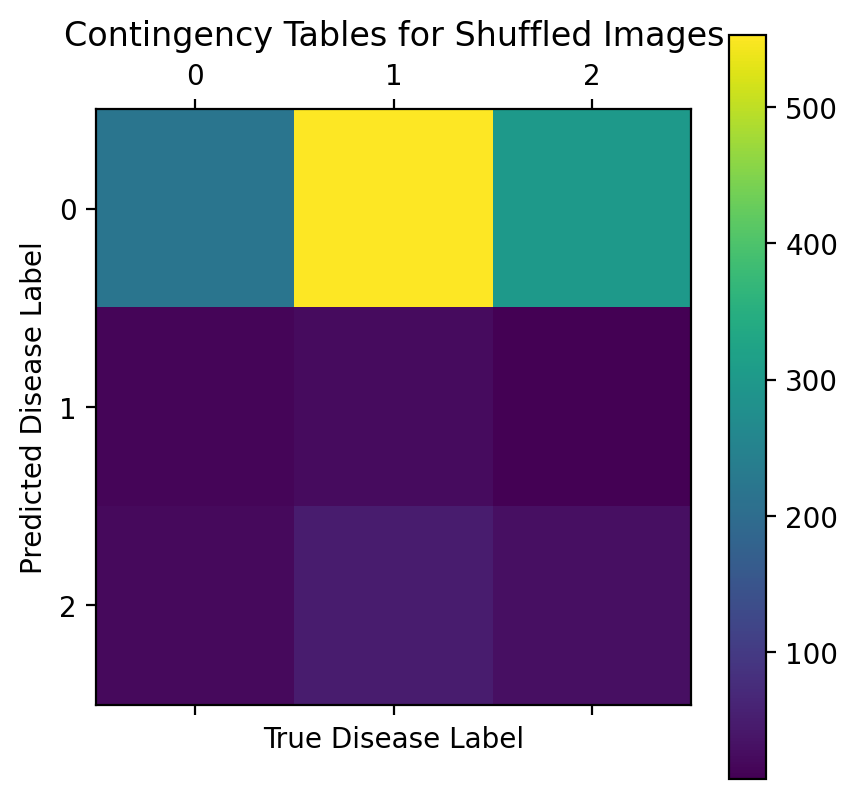

In [168]:
# create contingency table
contingency = np.zeros((3, 3))
for (p, t) in zip(pred, true):
    contingency[p][t] += 1
plt.matshow(contingency)
plt.title("Contingency Tables for Shuffled Images")
plt.xlabel("True Disease Label")
plt.ylabel("Predicted Disease Label")
plt.colorbar()

It looks like most everything is predicted to be Covid. I think that since there are no training images like those found in the shuffled set, during inference the model struggles to classify the scans. The data augmentation could be too violent. 

CNNs capable of learning spatially invariant features to some extent. However, there are limitations to this capability, especially if patches are moved or shuffled in a way that significantly alters the spatial relationships within the image. While CNNs are robust to small translations and distortions, they may struggle with more complex transformations that disrupt the spatial structure of the image

#### 3c. Remove parts of an image

In [169]:
def perturbate_images(images, perturbated_loc):
    perturbated_images = []
    # Assuming train_images is a list of images and train_images[0] is the first image
    for image in images:
        temp = []

        # Split the image into blocks of size (20, 20, 3)
        blocks = view_as_blocks(image, (20, 20, 3))

        for i in range(5):
            for j in range(5):
                if (i, j) == perturbated_loc:
                    temp.append(np.zeros((1, 20, 20, 3), dtype=np.float32))  # Specify dtype=float32
                else:
                    temp.append(blocks[i][j])
       
        # Concatenate the matrices along the rows to create a big matrix
        big_matrix = np.concatenate(temp, axis=0)

        # Reshape the big matrix to (100, 100, 3)
        big_matrix = big_matrix.reshape(5, 5, 20, 20, 3)

        # Combine the small matrices into one big matrix
        result = np.concatenate([np.concatenate(row, axis=1) for row in big_matrix], axis=0)

        # Verify the shape of the resulting matrix
        perturbated_images.append(result)
    return perturbated_images

Display some of the perturbated images.

<class 'numpy.ndarray'>


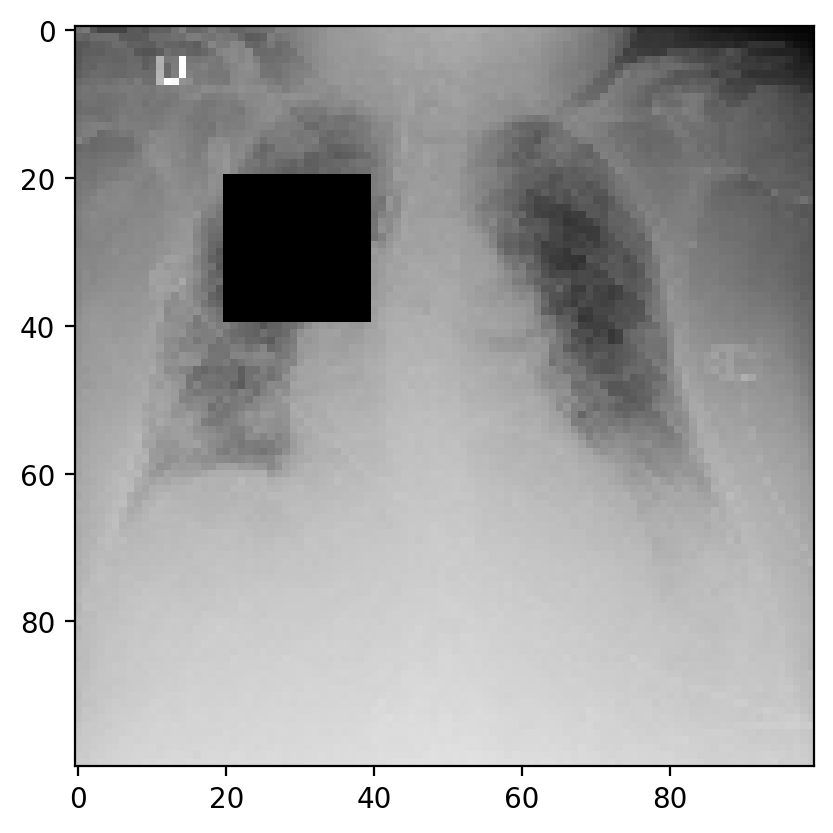

<class 'numpy.ndarray'>


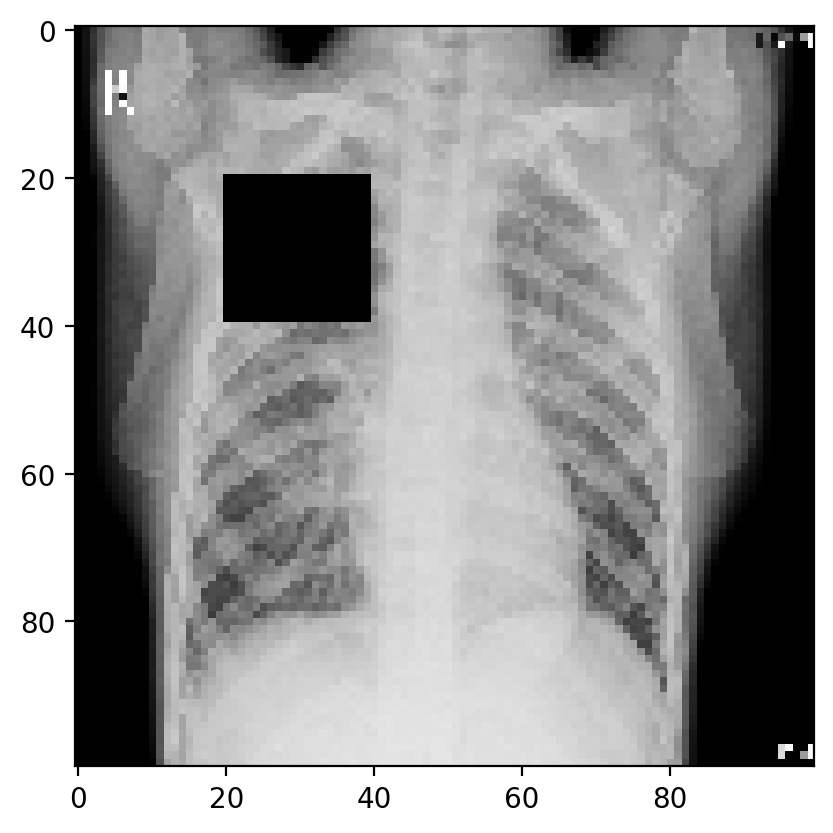

<class 'numpy.ndarray'>


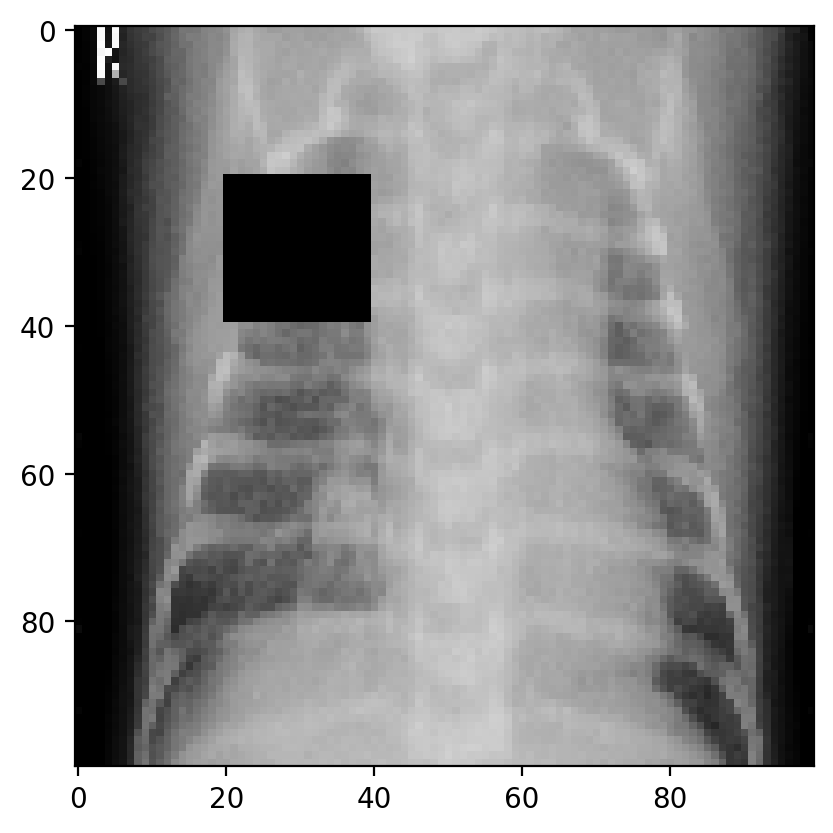

In [170]:
perturbated_test_images = perturbate_images(test_images, (1, 1))
for i in range(3):
    random_img = random.choice(perturbated_test_images)
    print(type(random_img))
    plt.imshow(random_img.astype(float) / 255.0, interpolation='nearest')
    plt.show()

#### 3d. Test the network on perturbated images and display a contingency matrix

Perturbated Images with Perturbation Loc: (0, 0) accuracy: 95.066
Perturbated Images with Perturbation Loc: (0, 1) accuracy: 70.888
Perturbated Images with Perturbation Loc: (0, 2) accuracy: 42.434
Perturbated Images with Perturbation Loc: (0, 3) accuracy: 25.082
Perturbated Images with Perturbation Loc: (0, 4) accuracy: 92.845
Perturbated Images with Perturbation Loc: (1, 0) accuracy: 36.349
Perturbated Images with Perturbation Loc: (1, 1) accuracy: 59.375
Perturbated Images with Perturbation Loc: (1, 2) accuracy: 44.243
Perturbated Images with Perturbation Loc: (1, 3) accuracy: 21.135
Perturbated Images with Perturbation Loc: (1, 4) accuracy: 60.526
Perturbated Images with Perturbation Loc: (2, 0) accuracy: 41.612
Perturbated Images with Perturbation Loc: (2, 1) accuracy: 26.974
Perturbated Images with Perturbation Loc: (2, 2) accuracy: 24.589
Perturbated Images with Perturbation Loc: (2, 3) accuracy: 29.276
Perturbated Images with Perturbation Loc: (2, 4) accuracy: 94.572
Perturbate

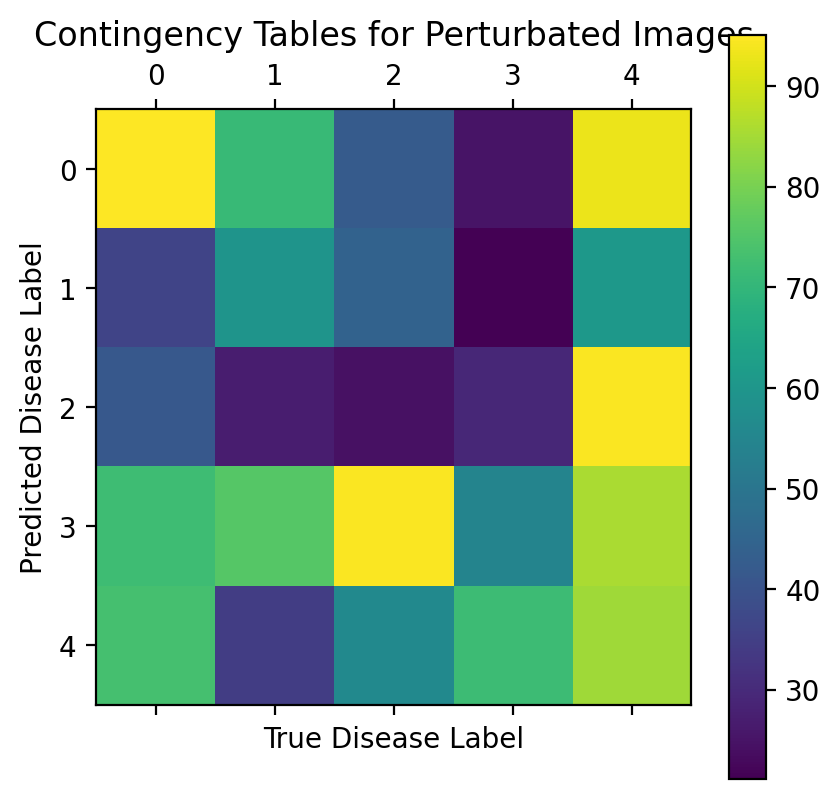

In [171]:
# create contingency table
contingency = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        perturbated_images = perturbate_images(test_images, (i, j))
        torch_perturbated_test_images = torch_inputs(perturbated_images)
        torch_test_labels = torch_labels(test_labels)
        acc, true, pred = test_network(model, 
                                       torch_perturbated_test_images,
                                       torch_test_labels,
                                       f"Perturbated Images with Perturbation Loc: {(i, j)}")
        contingency[i][j] += acc

plt.matshow(contingency)
plt.title("Contingency Tables for Perturbated Images")
plt.xlabel("True Disease Label")
plt.ylabel("Predicted Disease Label")
plt.colorbar()

The model appears to do fine when images away from the top and center are perturbated. When locations like (2, 2) are perturbated, the model performs at its worst. I believe that there is likely a lot of valuable information in a chest scan closer to the center, as the periphery tends to be areas of dark. Leaving out the center can cause the model to be confused at what its looking at.